<a href="https://colab.research.google.com/github/eisbetterthanpi/python/blob/master/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_dir = 'samples'
if not os.path.exists(sample_dir): os.makedirs(sample_dir)

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),)
batch_size = 4 # 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

image_size = 784
h_dim = 400
z_dim = 20
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        # return F.sigmoid(self.fc5(h))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 3 #15
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        # reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # Appendix B in VAE paper or http://yunjey47.tistory.com/43
        
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 1000 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}".format(epoch+1, num_epochs, i+1, len(train_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

Epoch[1/3], Step [1000/15000], Reconst Loss: 479.6361, KL Div: 55.0972
Epoch[1/3], Step [2000/15000], Reconst Loss: 443.0803, KL Div: 87.1898
Epoch[1/3], Step [3000/15000], Reconst Loss: 428.8863, KL Div: 98.8944
Epoch[1/3], Step [4000/15000], Reconst Loss: 281.2403, KL Div: 88.6129
Epoch[1/3], Step [5000/15000], Reconst Loss: 401.2626, KL Div: 94.2985
Epoch[1/3], Step [6000/15000], Reconst Loss: 342.0679, KL Div: 77.6048
Epoch[1/3], Step [7000/15000], Reconst Loss: 445.0544, KL Div: 91.4413
Epoch[1/3], Step [8000/15000], Reconst Loss: 518.7750, KL Div: 98.8455
Epoch[1/3], Step [9000/15000], Reconst Loss: 495.2442, KL Div: 102.8892
Epoch[1/3], Step [10000/15000], Reconst Loss: 449.6017, KL Div: 126.2344
Epoch[1/3], Step [11000/15000], Reconst Loss: 380.2337, KL Div: 105.6097
Epoch[1/3], Step [12000/15000], Reconst Loss: 411.7856, KL Div: 110.5115
Epoch[1/3], Step [13000/15000], Reconst Loss: 321.1584, KL Div: 93.7259
Epoch[1/3], Step [14000/15000], Reconst Loss: 401.1944, KL Div: 86.86

347


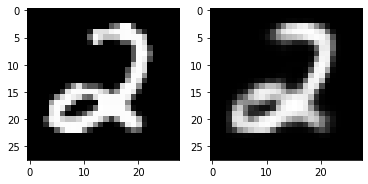

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

import random
n=random.randint(0,1000)
print(n)
x, y = train_data[n][0], train_data[n][1]
x_real=np.squeeze(x)

x = x.to(device).view(-1, image_size)
x_reconst, mu, log_var = model(x)
x_reconst=x_reconst.detach().numpy()
x_reconst=np.reshape(x_reconst,(28,28))

figure, axis = plt.subplots(1, 2)
axis[0].imshow(x_real, cmap = 'gray')
axis[1].imshow(x_reconst, cmap = 'gray')
plt.show()
